In [114]:
from tensorflow import keras
from keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dense, Dropout
from keras import layers
from PIL import Image
import numpy as np
from keras.optimizers import SGD, Adam
from keras.layers import Flatten
from keras.models import Sequential
import tensorflow as tf
import os
import winsound
from numpy import expand_dims
from keras.saving.save import load_model
from matplotlib import pyplot

In [115]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7949284200637160080
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2232716492
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8840897189334022995
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [116]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [117]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = expand_dims(X_train, axis=-1)
X_train = X_train.astype('float32')
X_train = X_train/255

In [118]:
def choose_real_images(real_data, number_of_samples):
	choosen_images = np.random.randint(0, real_data.shape[0], number_of_samples)
	X = real_data[choosen_images]
	y = np.ones((number_of_samples, 1))
	return X, y

In [119]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [120]:
def choose_fake_images(generator, latent_dim, number_of_samples):
	x_input = generate_latent_points(latent_dim, number_of_samples)
	X = generator.predict(x_input)
	y = np.zeros((number_of_samples, 1))
	return X, y

In [121]:
def define_generator(noise_size):
    n_nodes = 128 * 7 * 7

    model = Sequential()
    model.add(Dense(n_nodes, input_dim=noise_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))

    return model

In [122]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [123]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [124]:
def train_model(generator, discriminator,real_data,latent_dim,epochs=50, batch=128):
	gan=define_gan(generator, discriminator)
	batch_size=int(real_data.shape[0]/batch)
	number_of_samples=int(batch/2)
	for i in range(epochs):
		for j in range(batch_size):
			X_real, y_real = choose_real_images(real_data, number_of_samples)
			d_loss1= discriminator.train_on_batch(X_real, y_real)

			X_fake, y_fake = choose_fake_images(generator, latent_dim, number_of_samples)
			d_loss2= discriminator.train_on_batch(X_fake, y_fake)

			X_gan = generate_latent_points(latent_dim, batch)
			y_gan = np.ones((batch, 1))
			g_loss = gan.train_on_batch(X_gan, y_gan)
			print('epoch:%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, batch_size, d_loss1[0],
																d_loss2[0], g_loss))
	model.save('generator.h5')
	return generator

In [125]:
latent_dim=100

discriminator = define_discriminator()
generator = define_generator(latent_dim)

model=train_model(generator, discriminator,X_train,latent_dim)

2/2 [==============================] - 0s 53ms/step
epoch:1, 1/468, d1=0.692, d2=0.695 g=0.693
2/2 [==============================] - 0s 8ms/step
epoch:1, 2/468, d1=0.667, d2=0.700 g=0.687
2/2 [==============================] - 0s 8ms/step
epoch:1, 3/468, d1=0.639, d2=0.709 g=0.680
2/2 [==============================] - 0s 8ms/step
epoch:1, 4/468, d1=0.618, d2=0.720 g=0.671
2/2 [==============================] - 0s 7ms/step
epoch:1, 5/468, d1=0.606, d2=0.732 g=0.664
2/2 [==============================] - 0s 8ms/step
epoch:1, 6/468, d1=0.587, d2=0.742 g=0.662
2/2 [==============================] - 0s 8ms/step
epoch:1, 7/468, d1=0.585, d2=0.740 g=0.674
2/2 [==============================] - 0s 8ms/step
epoch:1, 8/468, d1=0.575, d2=0.718 g=0.700
2/2 [==============================] - 0s 7ms/step
epoch:1, 9/468, d1=0.593, d2=0.688 g=0.736
2/2 [==============================] - 0s 7ms/step
epoch:1, 10/468, d1=0.563, d2=0.659 g=0.760
2/2 [==============================] - 0s 7ms/step
epoch:1

In [126]:
duration = 500
freq = 300
winsound.Beep(freq, duration)

In [127]:
model.save('generator.h5')

In [128]:
'''img=Image.fromarray(np.reshape((model.predict(noise[0:1])[0]*25500),(28,28)))
img.show()
print(np.reshape((model.predict(noise[0:1])[0]*255),(28,28)))
print("\n\n")
print(np.reshape((model.predict(noise[0:1])[0]*25500),(28,28)))
img=Image.fromarray(np.reshape((model.predict(noise[0:1])[0]*255),(28,28)))
img.show()'''

'img=Image.fromarray(np.reshape((model.predict(noise[0:1])[0]*25500),(28,28)))\nimg.show()\nprint(np.reshape((model.predict(noise[0:1])[0]*255),(28,28)))\nprint("\n\n")\nprint(np.reshape((model.predict(noise[0:1])[0]*25500),(28,28)))\nimg=Image.fromarray(np.reshape((model.predict(noise[0:1])[0]*255),(28,28)))\nimg.show()'

4/4 [==============================] - 0s 14ms/step


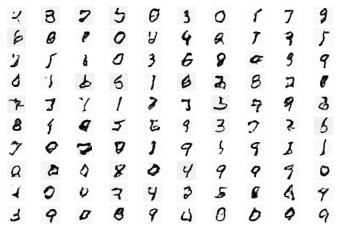

In [129]:
def show_plot(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

generated_model = load_model('generator.h5')
latent_points = generate_latent_points(100, 100)
pred = model.predict(latent_points)
show_plot(pred, 10)